In [1]:
import tensorflow as tf
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt
import utils
import scipy.spatial as spatial
import json
from random import choice, sample
from tqdm.notebook import tqdm
from rdkit import Chem
from rdkit.Chem import Descriptors
from gc import collect
from more_itertools import powerset

with open("data/Drugbank2019_MS_CFMID4.0.json", mode = "r") as drugbank:
    db = json.load(drugbank)

%matplotlib inline

2022-01-20 13:22:08.303436: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-20 13:22:08.303470: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
spectra = dict()

mol_indices = list(sample(list(range(len(db))), 1))
mol_strings = np.asarray(list(db.keys()))[ mol_indices ]

for m in tqdm(mol_strings):
    energies = [
        np.asarray([ utils.split_fpn(x) for x in db[m]["energy0"]["mz"] ]),
        np.asarray([ utils.split_fpn(x) for x in db[m]["energy1"]["mz"] ]),
        np.asarray([ utils.split_fpn(x) for x in db[m]["energy2"]["mz"] ])
    ]
    for i,energy in enumerate(energies):
        energies[i][:,0] = np.log(energy[:,0])/np.log(6000)
        
    spectra[m] = tuple(energies)

mol_strings = list(spectra.keys())
print(mol_strings)

  0%|          | 0/1 [00:00<?, ?it/s]

['CC(=O)O[C@H](C(=O)Nc1cccc2C(=O)NC(=O)C(=O)c12)c3cccc(Cl)c3']


In [3]:
(X0,X1,X2) = spectra[ mol_strings[0] ]
X = X0
dimension = X.shape[1]

In [4]:
def cayley_menger_matrix(X):
    d = X.shape[1]
    dm = np.power(spatial.distance_matrix(X,X), 2)
    m = np.zeros(np.asarray(dm.shape) + 1)
    m[:,0] = 1
    m[0,:] = 1
    m[0,0] = 0
    m[1:,1:] = dm
    return m

<IPython.core.display.Javascript object>


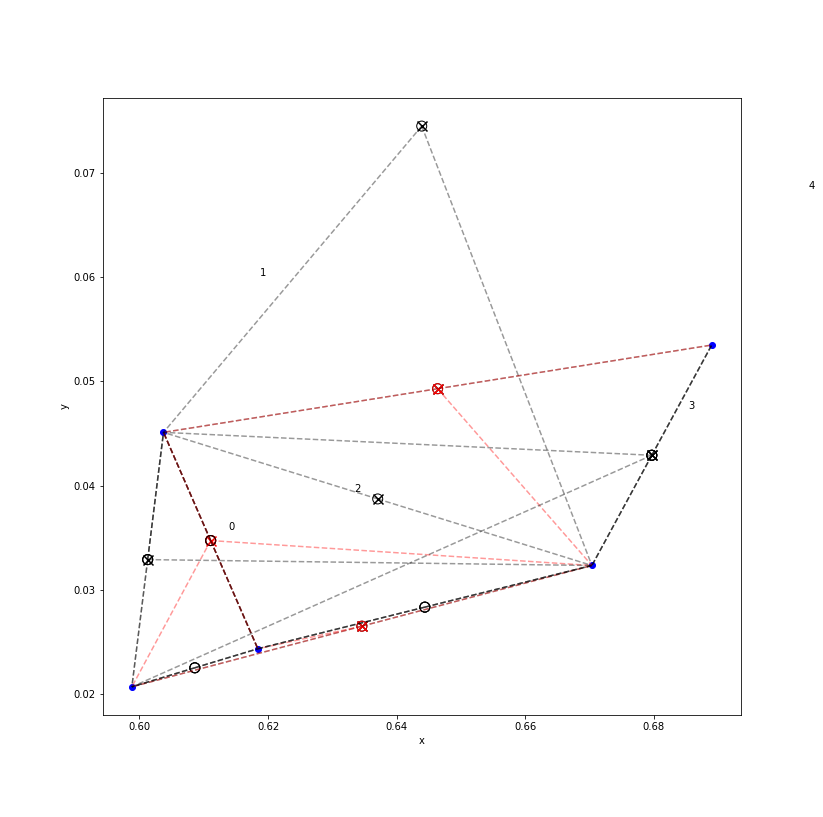

[((0,), 0.0), ((1,), 0.0), ((2,), 0.0), ((3,), 0.0), ((4,), 0.0), ((0, 2), 0.009962871536805858), ((0, 1), 0.01244048115797361), ((1, 2), 0.0127020017528491), ((0, 1, 2), 0.013695314449669932), ((3, 4), 0.014085309190150113), ((2, 3), 0.02628223897860482), ((1, 2, 3), 0.03791379427800845), ((1, 3), 0.03791379427800845), ((1, 3, 4), 0.04974316767045257), ((1, 4), 0.04974316767045257), ((0, 2, 3), 1.139233536800945), ((0, 3), 1.139233536800945)]


In [5]:
%matplotlib notebook

if True:
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(projection = "3d") if dimension == 3 else fig.add_subplot()
else:
    ax = None

tri = list() if dimension == 3 else None
kdtree = spatial.KDTree(X) # X is in R^d
cech_complex = dict()

triangulation = spatial.Delaunay(X)
delaunay_complex = [ list(powerset(face)) for face in triangulation.simplices ]
delaunay_complex = set([ tuple(sorted(list(item))) for sublist in delaunay_complex for item in sublist])

if dimension == 3:
    for face in delaunay_complex:
        if len(face) == 3:
            tri.append(face)

filtration = { (i,) : 0.0 for i in range(X.shape[0]) }

for i in reversed(range(1, dimension + 1)):
    faces = [ f for f in delaunay_complex if len(f) == (i + 1) ]
    for f in faces:
        if f not in filtration:
            content_inv  = np.linalg.inv(cayley_menger_matrix( X[f,:] ))
            circumradius = np.sqrt(content_inv[0,0]/-2)
            circumcentre = content_inv[1:,0].dot( X[f,:] )
            filtration[f] = circumradius
        #
        subfaces = [ tuple(sorted(list(tau))) for tau in set(powerset(f)) if len(tau) > 1]
        for t in subfaces:
            if t in filtration:
                filtration[t] = min(filtration[t], filtration[f])
            else:
                content_inv  = np.linalg.inv(cayley_menger_matrix( X[t,:] ))
                circumradius = np.sqrt(content_inv[0,0]/-2)
                circumcentre = content_inv[1:,0].dot( X[t,:] )
                _,nn = kdtree.query(circumcentre, k = len(t))
                if set(nn) != set(t): # not Gabriel
                    filtration[t] = filtration[f]
            
            #---- PLOTTING
            if ax is not None:
                plot_color = { 2 : "black", 3 : "red", 4 : "blue" }
                plot_color = plot_color[len(t)]
                ax.scatter(
                    *tuple(circumcentre),
                    color = plot_color,
                    marker = "o",
                    facecolors='none',
                    s = 100,
                    alpha = 1
                )
                for y in X[t, :]:
                    connecting_lines = (
                        [circumcentre[0],y[0]],
                        [circumcentre[1],y[1]],
                        [circumcentre[2],y[2]]
                    ) if dimension == 3 else (
                        [circumcentre[0],y[0]],
                        [circumcentre[1],y[1]],
                    )
                    ax.plot(
                        *connecting_lines,
                        "--",
                        color = plot_color,
                        alpha = 0.4
                    )
                _,nn = kdtree.query(circumcentre, k = len(t))
                if set(nn) != set(t):
                    ax.scatter(
                        *tuple(circumcentre),
                        color = plot_color,
                        marker = "x",
                        s = 100,
                        alpha = 1
                    )
#

cech_complex = sorted(list(filtration.items()), key = lambda t : t[1])

if ax is not None:
    if dimension == 3:
        plt_tri = a3.art3d.Poly3DCollection(X[tri, :])
        plt_tri.set_alpha(0.1)
        plt_tri.set_color('grey')
        ax.add_collection3d(plt_tri)

    for i,x in enumerate(X):
        ax.scatter(*tuple(x), color = "blue")
        ax.text(*tuple(x+0.015), s=str(i))

    #ax.set_xlim(0,1)
    #ax.set_ylim(0,1)
    #ax.set_zlim(0,1) if dimension == 3 else None
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z") if dimension == 3 else None
    plt.show()
print(cech_complex)